# 1. Load the data and library

In [1]:
# Importing Necessary Python Libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
from pandas import DateOffset
import sys
import os
import platform
import random
from math import sqrt, floor, ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from multiprocessing import Process
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

In [2]:
#CRSP Data

# Importing CRSP price and returns datasets
Returns = pd.read_csv(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\return\MonthlyRet_198001_202312csv.zip") #Importing Cleaned CRSP data

# Handling Missing values
Returns.PRC = abs(Returns.PRC)                                         # Converting Price Values to absolute numbers (CRSP sets PRC with a "-" symbol if it is comuted as bid-ask average when there is no actual trade)

# Market Cap Calculation
Returns['marketcap'] = Returns.SHROUT * Returns.PRC                    # Calculating Market Capitalization
Returns['marketcap'] = Returns.groupby('PERMNO')['marketcap'].shift()  # Lagged Market Capitalization
Returns['marketcap'] = Returns['marketcap'].apply(lambda x: 0.5 if x < 0.5 else x) #setting market cap to a min value of .5 because market_cap happend to be zero for some stocks, and b2m becomes unbounded

# Exchange Code Filters
exch_nyse_amex_Nasdaq = ['N', 'Q', 'A']
Returns = Returns[Returns.PRIMEXCH.isin(exch_nyse_amex_Nasdaq)].copy() #keeping only NYSE (N), AMEX(A) and Nasdaq (Q) stocks, ie. stocks listed on  US exchanges)

#Keep only ordinary common shares
ord_common_shares = [10, 11, 12]
Returns = Returns[Returns.SHRCD.isin(ord_common_shares)].copy()             #keeping only ordinary common shares - excludes unit trusts, ADRS, REITS, closed-end funds

# Minor Pre-processing
Returns.reset_index(inplace = True, drop = True)                                                # Reset Index

Returns = Returns[["PERMNO","PRIMEXCH","date","RET","PRC","SHROUT","marketcap","CFACSHR"]].copy() # Reordering the columns for clarity
Returns.RET = pd.to_numeric(Returns.RET, errors = 'coerce')                      #RET denoted missing value with alphanumeric values. convert it to Numeric with the 'coerce' option to set nonnumeric value to nan.

Returns.dropna(inplace = True)
#CRSP Data , prepare Date-time for merging with Compustat data

Returns["date"] = pd.to_datetime(Returns["date"])                       # Convert  "date" to a DateTime object
Returns["year"] = Returns["date"].dt.year                              # Extracting year
Returns["month"] = Returns["date"].dt.month                            # Extracting month

print("***********************************************************")
print("Returns dataframe from CRSP dataset")
print("***********************************************************")
Returns

***********************************************************
Returns dataframe from CRSP dataset
***********************************************************


,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,CFACSHR,year,month
1,10000,Q,1986-02-28,-0.257143,3.25000,3680.0,1.610000e+04,1.0,1986,2
2,10000,Q,1986-03-31,0.365385,4.43750,3680.0,1.196000e+04,1.0,1986,3
3,10000,Q,1986-04-30,-0.098592,4.00000,3793.0,1.633000e+04,1.0,1986,4
4,10000,Q,1986-05-30,-0.222656,3.10938,3793.0,1.517200e+04,1.0,1986,5
5,10000,Q,1986-06-30,-0.005025,3.09375,3793.0,1.179388e+04,1.0,1986,6
...,...,...,...,...,...,...,...,...,...,...
2944894,93436,Q,2023-08-31,-0.034962,258.07999,3173994.0,8.488212e+08,1.0,2023,8
2944895,93436,Q,2023-09-29,-0.030456,250.22000,3179000.0,8.191443e+08,1.0,2023,9
2944896,93436,Q,2023-10-31,-0.197346,200.84000,3178921.0,7.954494e+08,1.0,2023,10
2944897,93436,Q,2023-11-30,0.195379,240.08000,3178921.0,6.384545e+08,1.0,2023,11


In [3]:
# Date-time Manipulations
Returns.sort_values(by = ['PERMNO','date'], inplace = True)
#Compute two signals: 'new_issue' and 'ret_2_12'
Returns['SHROUT_adj'] = Returns.SHROUT*Returns.CFACSHR                            #adjust for stock splits before computing new issues. Why?
Returns['SHROUT_adj_lag12'] = Returns.groupby('PERMNO')['SHROUT_adj'].shift(12)
Returns['new_issue_asof_monthend'] =(Returns['SHROUT_adj'] - Returns['SHROUT_adj_lag12'])/Returns['SHROUT_adj_lag12']
Returns['new_issue'] = Returns.groupby('PERMNO')['new_issue_asof_monthend'].shift()                                 #Why shift ?

#compute compunded returns from month t-12 to t-2
Returns['ret_2_12'] = 1
for i in range(2,13):
    Returns['ret_2_12'] =  Returns['ret_2_12'] *  (1 + Returns.groupby('PERMNO')['RET'].shift(i))
#Returns
count = count = Returns.groupby('date').count()
count

,PERMNO,PRIMEXCH,RET,PRC,SHROUT,marketcap,CFACSHR,year,month,SHROUT_adj,SHROUT_adj_lag12,new_issue_asof_monthend,new_issue,ret_2_12
date,,,,,,,,,,,,,,
1980-02-29,4550,4550,4550,4550,4550,4550,4550,4550,4550,4550,0,0,0,0
1980-03-31,4551,4551,4551,4551,4551,4551,4551,4551,4551,4551,0,0,0,0
1980-04-30,4550,4550,4550,4550,4550,4550,4550,4550,4550,4550,0,0,0,0
1980-05-30,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,0,0,0,0
1980-06-30,4557,4557,4557,4557,4557,4557,4557,4557,4557,4557,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,5048,5048,5048,5048,5048,5048,5048,5048,5048,5048,4828,4828,4813,4828
2023-09-29,5032,5032,5032,5032,5032,5032,5032,5032,5032,5032,4816,4816,4791,4816
2023-10-31,5005,5005,5005,5005,5005,5005,5005,5005,5005,5005,4785,4785,4764,4785


# 2. Create Features

## 2.1 Adding New Features 

## Explanation of Selected Features for Stock Return Prediction

## 1. Debt-to-Equity Ratio

- **Formula**: Debt-to-Equity Ratio = (Current Liabilities + Long-Term Debt) / Total Shareholders' Equity
- **Reason to Use**: The Debt-to-Equity Ratio is a key indicator of a company's financial leverage. Companies with higher leverage are seen as riskier, as they rely more on debt to fuel their growth, which can make their earnings more volatile. Conversely, lower leverage indicates less dependency on debt, which can be seen as a sign of financial stability. This ratio is particularly useful in assessing how a company is positioned to withstand economic downturns and its capacity to continue funding its operations, both of which are critical for long-term investment considerations.
- **Conventional Status**: Yes, the Debt-to-Equity Ratio is a conventional metric widely used in credit analysis and risk assessment. It helps investors understand a company's risk level in terms of its capital structure, making it a valuable tool for predicting stock returns, especially in industries where capital structure significantly influences company performance.

### 2. Return on Assets (ROA)
- **Formula**: Return on Assets = Net Income / Total Assets
- **Reason to Use**: ROA indicates how efficiently a company can manage its assets to produce profits during a period. A higher ROA shows a company is more efficient in using its assets to generate earnings. For investors, a consistent increase in ROA is a positive indicator of management efficiency and an aspect closely watched for predicting future growth in earnings and, by extension, in stock returns.
- **Conventional Status**: Absolutely, ROA is a staple metric in financial analysis used to compare profitability levels across companies, regardless of size. It's critical for evaluating how well a company is deploying its assets to generate earnings.

### 3. Price to Earnings (P/E) Ratio
- **Formula**: P/E Ratio = Market Cap / Net Income
- **Reason to Use**: The P/E ratio is used to determine the market's valuation of a company's earnings. A high P/E ratio could mean that the market expects higher earnings growth in the future compared to companies with a lower P/E ratio. Investors use this ratio to predict future earnings growth and the potential for stock price increases. The relationship between a company's P/E ratio and its stock price can indicate whether the stock is undervalued or overvalued, providing a basis for return prediction.
- **Conventional Status**: The P/E ratio is one of the most widely recognized valuation metrics in equity analysis. It is frequently used by investors and analysts to assess stock price valuations and is considered essential for investment decisions.





These metrics are foundational in financial analysis and are routinely used to assess a company's operational and financial health. By integrating these measures into a predictive model for stock returns, one can leverage conventional financial wisdom along with quantitative analysis techniques to anticipate future stock performance.


Merge CRSP and Compusta data by PERMNO.
Ensure no look-ahead bias:

In [4]:
#Compustat Data

# Importing Compustat Data
Cstat_data = pd.read_csv(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\return\Compustatdata_for_signals_1980_2023.csv")     # Importing monthly Compustat data
Cstat_data['lag_at'] = Cstat_data.groupby('LPERMNO')['at'].shift()                                 #assets the previous fiscal year
Cstat_data["date"] = pd.to_datetime(Cstat_data["datadate"], format="%Y%m%d")                      # "date" is set to DateTime object
Cstat_data['date'] = Cstat_data['date'].apply(lambda x: x + DateOffset(months=+5)) # Adding five months (using DataOffset library) assuming it takes at most 4 months for the data to reach the market

Cstat_data.sort_values(by = 'date', inplace = True)                                    # Sort by date
#Cstat_data["SeqNo_cstat"] = (Cstat_data['date']).rank(method = "dense").astype(int)
Cstat_data.rename(columns = {'LPERMNO' : 'PERMNO'}, inplace = True)
Returns.sort_values(by = 'date', inplace = True)
Cstat_data.sort_values(by = 'date', inplace = True)

merged_data = pd.merge_asof(Returns, Cstat_data, by = 'PERMNO', left_on = 'date', right_on = 'date', tolerance=dt.timedelta(days = 365))

In [5]:

# Compute additional signals
merged_data['investment'] = merged_data['at']/ merged_data['lag_at'] - 1
merged_data['accruals'] = (merged_data['ib'] - merged_data['oancf'])/ merged_data['at']
merged_data['b2m'] = merged_data['ceq'] / merged_data['marketcap']
# the 3 new created metrics
merged_data['Debt_to_Equity'] = (merged_data['dlc'] + merged_data['dltt']) / merged_data['ceq']
merged_data['ROA'] = merged_data['ni'] / merged_data['at']
merged_data['PE_Ratio'] = merged_data['marketcap'] / merged_data['ni']

signals = ['marketcap', 'new_issue', 'investment', 'accruals', 'b2m', 'Debt_to_Equity','ROA','PE_Ratio' ]
merged_data.dropna(subset = signals, how = 'any', inplace = True)               #Drop only if signals are na
merged_data = merged_data[merged_data.date.dt.year > 1989]

merged_data


,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,CFACSHR,year,month,...,xrd,xsga,costat,lag_at,investment,accruals,b2m,Debt_to_Equity,ROA,PE_Ratio
677386,56119,N,1990-01-31,-0.069364,20.12500,7155.0,1.547269e+05,2.25,1990,1,...,NaN,91.168,I,141.036,0.079561,0.009412,0.000615,0.137558,0.085448,11892.918909
677387,11339,Q,1990-01-31,-0.109375,14.25000,9209.0,1.473440e+05,1.00,1990,1,...,6.655,23.651,I,40.189,0.525567,0.102673,0.000254,0.337604,0.123974,19384.817787
677388,62447,Q,1990-01-31,-0.175439,1.46875,10756.0,1.796925e+04,0.60,1990,1,...,3.473,15.232,I,31.647,0.071128,-0.204732,0.000365,2.849947,0.004042,131162.408759
677389,11174,Q,1990-01-31,-0.132530,1.12500,3714.0,4.816612e+03,1.50,1990,1,...,NaN,0.965,A,4.412,0.486627,0.724958,0.000875,0.333571,0.193170,3801.588256
677390,34033,Q,1990-01-31,-0.200000,0.12500,4476.0,6.993750e+02,1.00,1990,1,...,0.172,3.247,I,5.283,-0.143479,-0.149834,0.001421,2.505030,-0.101878,-1517.082430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890770,19880,N,2023-12-29,0.248681,75.72000,78823.0,4.779827e+06,1.00,2023,12,...,NaN,507.437,A,7121.393,0.304978,-0.034320,0.000573,1.283980,0.003589,143305.951910
2890772,87487,Q,2023-12-29,0.110769,7.22000,386791.0,2.514142e+06,1.00,2023,12,...,NaN,NaN,A,3342.166,-0.079947,-0.057122,0.000266,1.811823,0.015841,51612.364510
2890773,11174,Q,2023-12-29,-0.051333,75.77000,6383.0,5.098102e+05,1.00,2023,12,...,0.000,529.556,A,1145.312,0.240213,0.109910,0.000978,1.406164,0.014356,25000.500687
2890774,17879,Q,2023-12-29,-0.154811,0.60000,28814.0,2.045506e+04,1.00,2023,12,...,5.848,13.101,A,25.987,-0.494863,-0.043574,0.000575,0.007742,-0.995734,-1564.919180


In [6]:
merged_data.isnull().sum()

PERMNO                           0
PRIMEXCH                         0
date                             0
RET                              0
PRC                              0
SHROUT                           0
marketcap                        0
CFACSHR                          0
year                             0
month                            0
SHROUT_adj                       0
SHROUT_adj_lag12                 0
new_issue_asof_monthend          0
new_issue                        0
ret_2_12                         0
GVKEY                            0
datadate                         0
fyear                            0
indfmt                           0
consol                           0
popsrc                           0
datafmt                          0
curcd                            0
at                               0
capx                         15442
ceq                              0
che                            133
cogs                             0
dlc                 

## 2.2. Compute decile for Features

In [7]:
features = ['new_issue', 'investment', 'accruals', 'b2m', 'Debt_to_Equity', 'ROA', 'PE_Ratio']
for feature in features:
    merged_data[f'{feature}_rank'] = merged_data.groupby(['year', 'month'])[feature].transform(lambda x: pd.qcut(x, 10, duplicates='drop', labels=False)) # CalcuAssign  Decile Ranks based on the Features 

merged_data

c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff

,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,CFACSHR,year,month,...,Debt_to_Equity,ROA,PE_Ratio,new_issue_rank,investment_rank,accruals_rank,b2m_rank,Debt_to_Equity_rank,ROA_rank,PE_Ratio_rank
677386,56119,N,1990-01-31,-0.069364,20.12500,7155.0,1.547269e+05,2.25,1990,1,...,0.137558,0.085448,11892.918909,4,5,7.0,5,2,7.0,5
677387,11339,Q,1990-01-31,-0.109375,14.25000,9209.0,1.473440e+05,1.00,1990,1,...,0.337604,0.123974,19384.817787,9,9,9.0,2,4,8.0,7
677388,62447,Q,1990-01-31,-0.175439,1.46875,10756.0,1.796925e+04,0.60,1990,1,...,2.849947,0.004042,131162.408759,8,4,0.0,3,9,3.0,9
677389,11174,Q,1990-01-31,-0.132530,1.12500,3714.0,4.816612e+03,1.50,1990,1,...,0.333571,0.193170,3801.588256,9,8,9.0,6,4,9.0,3
677390,34033,Q,1990-01-31,-0.200000,0.12500,4476.0,6.993750e+02,1.00,1990,1,...,2.505030,-0.101878,-1517.082430,2,1,1.0,8,9,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890770,19880,N,2023-12-29,0.248681,75.72000,78823.0,4.779827e+06,1.00,2023,12,...,1.283980,0.003589,143305.951910,4,9,5.0,4,7,4.0,9
2890772,87487,Q,2023-12-29,0.110769,7.22000,386791.0,2.514142e+06,1.00,2023,12,...,1.811823,0.015841,51612.364510,8,2,3.0,2,8,5.0,9
2890773,11174,Q,2023-12-29,-0.051333,75.77000,6383.0,5.098102e+05,1.00,2023,12,...,1.406164,0.014356,25000.500687,3,8,9.0,6,8,5.0,8
2890774,17879,Q,2023-12-29,-0.154811,0.60000,28814.0,2.045506e+04,1.00,2023,12,...,0.007742,-0.995734,-1564.919180,3,0,4.0,4,1,0.0,2


In [8]:
merged_data.columns

Index(['PERMNO', 'PRIMEXCH', 'date', 'RET', 'PRC', 'SHROUT', 'marketcap',
       'CFACSHR', 'year', 'month', 'SHROUT_adj', 'SHROUT_adj_lag12',
       'new_issue_asof_monthend', 'new_issue', 'ret_2_12', 'GVKEY', 'datadate',
       'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'at', 'capx',
       'ceq', 'che', 'cogs', 'dlc', 'dltt', 'dp', 'gp', 'ib', 'ni', 'oancf',
       'oiadp', 'ppenb', 'sale', 'txdb', 'xad', 'xrd', 'xsga', 'costat',
       'lag_at', 'investment', 'accruals', 'b2m', 'Debt_to_Equity', 'ROA',
       'PE_Ratio', 'new_issue_rank', 'investment_rank', 'accruals_rank',
       'b2m_rank', 'Debt_to_Equity_rank', 'ROA_rank', 'PE_Ratio_rank'],
      dtype='object')

In [9]:
merged_data.isnull().sum()

PERMNO                           0
PRIMEXCH                         0
date                             0
RET                              0
PRC                              0
SHROUT                           0
marketcap                        0
CFACSHR                          0
year                             0
month                            0
SHROUT_adj                       0
SHROUT_adj_lag12                 0
new_issue_asof_monthend          0
new_issue                        0
ret_2_12                         0
GVKEY                            0
datadate                         0
fyear                            0
indfmt                           0
consol                           0
popsrc                           0
datafmt                          0
curcd                            0
at                               0
capx                         15442
ceq                              0
che                            133
cogs                             0
dlc                 

# 3. Modeling

## 3.1 Random Forest

In [10]:
# Data Pre-processing

dat = merged_data.copy()

# Date-time Manipulations
dat["date"] = pd.to_datetime(dat["date"])                                       # "date" as a DateTime object
dat["yr"] = dat["date"].dt.year                                                 # Extracting year
dat["month"] = dat["date"].dt.month                                             # Extracting month
dat.sort_values(by = 'date', inplace = True)    

starting_year = 1990                                                            #Starting year.
dat = dat[dat.yr >= starting_year].copy()                                       #limited availablity of 'oancf' pre-1990. Set to the s
dat["month_num"] = (dat['date']).rank(method = "dense")
#Target is 'adj_return' = 'RET' - 'mean_ret' (average returns for all stocks that month) (why  adj_return and not RET?)
# Calculating Mean & Adjusted Returns
grouped = pd.DataFrame();                                                       # Initializing DataFrame
grouped["mean"] = dat.groupby('date').apply(lambda x : x["RET"].mean())       # Computing monthly mean returns
dat['mean_ret'] = dat['date'].map(grouped["mean"])                            # Assigning mean returns to "dat["mean_ret"]" column
dat['adj_ret'] = dat['RET'] - dat['mean_ret']                                   # Adjusted Returns - subtract the mean so that the target is return minus average returns for all stocks.

# Printing Output
print("***********************************************************")
print("Pre-processed Dataframe containing all signals")
print("***********************************************************")
dat

***********************************************************
Pre-processed Dataframe containing all signals
***********************************************************


,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,CFACSHR,year,month,...,investment_rank,accruals_rank,b2m_rank,Debt_to_Equity_rank,ROA_rank,PE_Ratio_rank,yr,month_num,mean_ret,adj_ret
677386,56119,N,1990-01-31,-0.069364,20.1250,7155.0,1.547269e+05,2.2500,1990,1,...,5,7.0,5,2,7.0,5,1990,1.0,-0.051288,-0.018076
681427,25144,N,1990-01-31,-0.093500,17.7500,38392.0,7.678400e+05,1.0000,1990,1,...,4,4.0,7,7,4.0,4,1990,1.0,-0.051288,-0.042212
681429,63546,A,1990-01-31,0.000000,9.6250,1871.0,1.800838e+04,0.0125,1990,1,...,5,8.0,6,0,8.0,5,1990,1.0,-0.051288,0.051288
681430,54501,Q,1990-01-31,-0.116279,1.1875,2251.0,3.026125e+03,1.0000,1990,1,...,8,9.0,8,7,3.0,9,1990,1.0,-0.051288,-0.064991
681431,78473,Q,1990-01-31,-0.018182,6.7500,1830.0,1.258125e+04,3.0000,1990,1,...,0,0.0,8,2,0.0,3,1990,1.0,-0.051288,0.033106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887365,20892,Q,2023-12-29,0.394484,173.9200,192049.0,2.395235e+07,1.0000,2023,12,...,9,6.0,2,5,3.0,1,2023,408.0,0.120579,0.273905
2887366,20891,Q,2023-12-29,0.396419,5.4600,221064.0,8.643602e+05,1.0000,2023,12,...,6,8.0,5,9,4.0,0,2023,408.0,0.120579,0.275840
2887368,90775,N,2023-12-29,0.018177,41.4500,55300.0,2.251263e+06,1.0000,2023,12,...,1,8.0,5,7,3.0,1,2023,408.0,0.120579,-0.102402
2887370,21970,Q,2023-12-29,0.182750,13.8500,43059.0,5.042209e+05,1.0000,2023,12,...,2,6.0,4,1,2.0,1,2023,408.0,0.120579,0.062171


In [11]:
## Defining Random Forest Regressor function with output features. The next block of codes call this function
# see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html for details

def random_forest_rolling(train_X, train_y, test_X, test_y) :

  # Running Random forest model
  regressor = RandomForestRegressor(n_estimators=trials, max_features= num_features, max_depth= max_tree_depth, random_state = 0).fit(train_X, train_y)    # Random Forest Regressor Model
                                                                            # random_state controls both the randomness of bagging and the sampling of the features to consider when looking for the best split
                                                                            #  at each node. Set equal to an integer for reproducability

  # Storing & returning the predicted returns based on the model
  prediction = regressor.predict(test_X)                                                                                                                    # Storing the predicted returns from the random forest model
  R2_score = regressor.score(test_X, test_y)                                                                                                                # Storing the R2 Score between predicted & observed values
  return prediction, R2_score

In [12]:
dat.isnull().sum()

PERMNO           0
PRIMEXCH         0
date             0
RET              0
PRC              0
                ..
PE_Ratio_rank    0
yr               0
month_num        0
mean_ret         0
adj_ret          0
Length: 61, dtype: int64

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Placeholder function for your random forest model, to be replaced with actual model call
def random_forest_rolling(train_X, train_y, test_X, test_y):
    # Define the imputer to handle NaN values
    imputer = SimpleImputer(strategy='median')
    train_X = imputer.fit_transform(train_X)
    test_X = imputer.transform(test_X)
    
    # Define and fit the model
    model = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
    model.fit(train_X, train_y)
    
    # Predict using the model
    predicted_returns = model.predict(test_X)
    return predicted_returns

## Random Forest: Input parameters
y_column_name = 'adj_ret'  # Adjusted Return is Dependent Variable
features = ['investment_rank', 'accruals_rank', 'b2m_rank', 'Debt_to_Equity_rank', 'ROA_rank', 'PE_Ratio_rank']
predicted_ret_df = pd.DataFrame()  # Initializing "predicted_ret_df"
rolling_window = 60  # Training data is comprised of all observations within this window
last_start_month = int(dat["month_num"].max()) - rolling_window  # identify the month to end the loop
start_time = datetime.now()

for t in range(1, last_start_month + 1):  # Iterating over various rolling windows

    # Training and Test Data Parameters
    train_month_start = t
    train_month_end = train_month_start + rolling_window

    # Extracting Training and Test Data
    train_dat = dat[(dat['month_num'] >= train_month_start) & (dat['month_num'] <= train_month_end)]
    test_dat = dat[dat['month_num'] == train_month_end + 1]
    
    if test_dat.empty:
        continue  # Skip the loop if no test data is available for the month

    train_X = train_dat[features]
    test_X = test_dat[features]
    train_y = train_dat[y_column_name]
    test_y = test_dat[y_column_name]

    # Predicting returns
    predicted_returns = random_forest_rolling(train_X, train_y, test_X, test_y)

    # Prepare test data results
    test_dat.loc[:, "predicted_adj_ret"] = predicted_returns
    test_dat.rename(columns={"adj_ret": "actual_adj_ret"}, inplace=True)
    test_dat = test_dat[["PERMNO", "yr", "month", "predicted_adj_ret", "actual_adj_ret", "RET"]]

    # Consolidate Predicted Returns
    predicted_ret_df = pd.concat([predicted_ret_df, test_dat], axis=0)

predicted_ret_df

C:\Users\ctlan\AppData\Local\Temp\ipykernel_22172\3030601530.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dat.loc[:, "predicted_adj_ret"] = predicted_returns
C:\Users\ctlan\AppData\Local\Temp\ipykernel_22172\3030601530.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dat.rename(columns={"adj_ret": "actual_adj_ret"}, inplace=True)
C:\Users\ctlan\AppData\Local\Temp\ipykernel_22172\3030601530.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,PERMNO,yr,month,predicted_adj_ret,actual_adj_ret,RET
1063786,78717,1995,2,-0.005494,0.082961,0.113553
1063782,76408,1995,2,0.002329,0.080519,0.111111
1063781,76981,1995,2,-0.001889,-0.030592,0.000000
1063779,23579,1995,2,-0.002778,0.029941,0.060533
1063811,75101,1995,2,-0.005494,-0.004276,0.026316
...,...,...,...,...,...,...
2887365,20892,2023,12,-0.001929,0.273905,0.394484
2887366,20891,2023,12,0.002660,0.275840,0.396419
2887368,90775,2023,12,0.001609,-0.102402,0.018177
2887370,21970,2023,12,0.001369,0.062171,0.182750


In [15]:
# Decile formation & Predicted Returns Calculation
predicted_ret_df['rank'] = predicted_ret_df.groupby(['yr','month'])['predicted_adj_ret'].transform(lambda x: pd.qcut(x, 10, duplicates='drop',labels=False))         # Calculating Decile Ranks based on the Predicted Returns
predicted_ret_df.reset_index(inplace =True,drop = True)                                                                                                                            # Reseting Index

## Print Output : Predicted_Ret_Df
print("****************************************************************************")
print("DataFrame with Adjusted Predicted Returns, Deciles(rank) ")
print("****************************************************************************")
predicted_ret_df

****************************************************************************
DataFrame with Adjusted Predicted Returns, Deciles(rank) 
****************************************************************************


,PERMNO,yr,month,predicted_adj_ret,actual_adj_ret,RET,rank
0,78717,1995,2,-0.005494,0.082961,0.113553,1
1,76408,1995,2,0.002329,0.080519,0.111111,5
2,76981,1995,2,-0.001889,-0.030592,0.000000,3
3,23579,1995,2,-0.002778,0.029941,0.060533,2
4,75101,1995,2,-0.005494,-0.004276,0.026316,1
...,...,...,...,...,...,...,...
1481374,20892,2023,12,-0.001929,0.273905,0.394484,1
1481375,20891,2023,12,0.002660,0.275840,0.396419,6
1481376,90775,2023,12,0.001609,-0.102402,0.018177,5
1481377,21970,2023,12,0.001369,0.062171,0.182750,5


In [16]:
predicted_ret_df['yr'].unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [17]:
# Monthly Mean Portfolio Returns
# predicted_ret_df['yr'] = pd.to_datetime(predicted_ret_df['date']).dt.year
# predicted_ret_df['month'] = pd.to_datetime(predicted_ret_df['date']).dt.month

meanret = predicted_ret_df.groupby(['yr','month', 'rank'])['RET'].mean().to_frame()      # Calculating average return for each decile (according to b2m ratio) for each month
meanret = meanret.unstack(level = -1).copy()                                             # Unstacking the grouped dataframe
meanret[('RET', 'diff')] = meanret[('RET', 9)] -  meanret[('RET', 0)]                    # Calculating the long short returns of the portfolio by substracting "rank 0" avg. return from "rank 9" avg. return
meanret = meanret.stack(level = -1).copy()   

In [18]:
# Overall Portfolio Returns Statistics
#post_year = 2010
post_year = 1990
meanret_slice = meanret[meanret.index.get_level_values(0)>=post_year].copy()                   #slice data post "post_year"
global_mean = meanret_slice.groupby('rank')['RET'].agg([np.mean, np.std])                      # mean and standard deviation of regression coefficients
nmon = len(meanret_slice.unstack(level = -1))                                                  #number of months in the sample - varies with 'post-year'
global_mean['t-stat'] =np.sqrt((nmon) - 1) *  global_mean['mean']/global_mean['std']           # t-statistics
#global_mean.to_csv("/content/drive/MyDrive/MAF data/globalmean_7sig_5_levels.csv")
global_mean

C:\Users\ctlan\AppData\Local\Temp\ipykernel_22172\305858410.py:5: FutureWarning: The provided callable <function mean at 0x00000187B0738A60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  global_mean = meanret_slice.groupby('rank')['RET'].agg([np.mean, np.std])                      # mean and standard deviation of regression coefficients
C:\Users\ctlan\AppData\Local\Temp\ipykernel_22172\305858410.py:5: FutureWarning: The provided callable <function std at 0x00000187B0738B80> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  global_mean = meanret_slice.groupby('rank')['RET'].agg([np.mean, np.std])                      # mean and standard deviation of regression coefficients


,mean,std,t-stat
rank,,,
0,0.005524,0.081125,1.266565
1,0.008673,0.067981,2.372974
2,0.010326,0.062398,3.078257
3,0.011361,0.060598,3.487239
4,0.012460,0.060839,3.809644
5,0.011375,0.058107,3.641475
6,0.013655,0.065470,3.879558
7,0.014287,0.068385,3.886149
8,0.019634,0.078160,4.672600


In [19]:
meanret_diff = meanret[meanret.index.get_level_values(2) == 'diff']             #A slice with only rows corresponding to 'diff'
meanret_diff

RET
yr   month rank          
1997 1     diff  0.058181
     3     diff  0.061907
     5     diff -0.044379
     9     diff  0.010018
     11    diff  0.011465
...                   ...
2021 10    diff -0.038327
     11    diff -0.046668
2022 11    diff  0.048697
2023 6     diff  0.031445
     9     diff  0.031614

[157 rows x 1 columns]

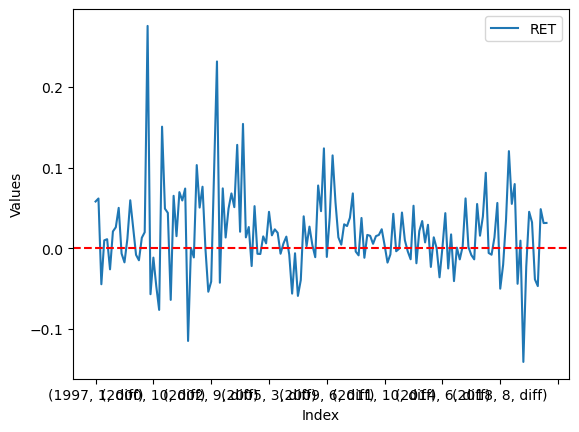

In [20]:
import matplotlib.pyplot as plt
meanret_diff.plot(kind='line')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

# 4. Test the performance

In [44]:
meanret

df = meanret.reset_index()

# The DataFrame should now have 'year' and 'month' as columns that can be forward-filled
df['yr'] = df['yr'].ffill()
df['month'] = df['month'].ffill()

df.rename(columns={'yr': 'year'}, inplace=True)
df

,year,month,rank,RET
0,1995,2,0,0.013411
1,1995,2,1,0.025050
2,1995,2,2,0.037692
3,1995,2,3,0.037185
4,1995,2,4,0.034136
...,...,...,...,...
3289,2023,12,4,0.201008
3290,2023,12,5,0.103596
3291,2023,12,6,0.123645
3292,2023,12,7,0.169202


## 4.1 calculate the alpha and beta for out profolio 

In [45]:
import statsmodels.api as sm

Mkt_Risk_freeRate = pd.read_csv(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\risk\Market_Riskfree_2312.csv")     # read market returns and risk-free rate
Mkt_Risk_freeRate['mkt_excess_returns'] = Mkt_Risk_freeRate['Market'] - Mkt_Risk_freeRate['RiskfreeRate'] #compute market excess returns
asset_returns = pd.merge(df, Mkt_Risk_freeRate, how = "inner", on = ['year', 'month'])
asset_returns['excess_returns'] = asset_returns['RET'] - asset_returns['RiskfreeRate'] #compute asset excess returns
asset_returns.loc[asset_returns['rank'] == 'diff',  'excess_returns'] = asset_returns['RET']  #Long - short returns  for diff
asset_returns['rank'] = asset_returns['rank'].astype(str)
ranks = set((asset_returns['rank'])) # determines ids for assets in the data
ranks_list = list(sorted(ranks))

asset_returns['constant'] = 1 #add constant to the regression to get the intercept

for decile in ranks_list:                                                         #Loop through the date to pick one rank at a time and estimate alpha and beta for that portfolio
    x = asset_returns[['constant', 'mkt_excess_returns', ]].loc[asset_returns['rank'] == decile].copy()
    y = asset_returns['excess_returns'].loc[asset_returns['rank'] == decile].copy()
    model = sm.OLS(y,x)
    results = model.fit()
 #Print out the regression estimates for one portfolio at a time. Then print the corresponding t-statistics
    print('************************************************')
    print('Decile:' , decile)
    print('**************** estimates of alpha and beta ****************' )
    print(results.params) #gets the parameters                                  #The coefficient on the constant(also referred to as the 'intercept')) is alpha
                                                                                # The coefficient on 'mkt_excess_returns' is beta

    print('******** t-statistics for alpha and beta ***********' )              #Use the t-stats on the constant to test whether alpha is signficantly different from zero.
                                                                                # The coefficient on 'mkt_excess_returns' is beta
    print(results.tvalues)

************************************************
Decile: 0
**************** estimates of alpha and beta ****************
constant             -0.006673
mkt_excess_returns    1.387765
dtype: float64
******** t-statistics for alpha and beta ***********
constant              -2.413188
mkt_excess_returns    23.228817
dtype: float64
************************************************
Decile: 1
**************** estimates of alpha and beta ****************
constant             -0.002350
mkt_excess_returns    1.237751
dtype: float64
******** t-statistics for alpha and beta ***********
constant              -1.145760
mkt_excess_returns    27.990846
dtype: float64
************************************************
Decile: 2
**************** estimates of alpha and beta ****************
constant              0.000102
mkt_excess_returns    1.161760
dtype: float64
******** t-statistics for alpha and beta ***********
constant               0.057690
mkt_excess_returns    30.516448
dtype: float64
**********

## 4.2 infromation ratio 

In [46]:
asset_returns['rp minus rm'] = asset_returns['RET'] - asset_returns['Market']
for rank in ranks:
  df = asset_returns.loc[asset_returns['rank'] == rank]
  tracking_error = df['rp minus rm'].std()
  Information_ratio_annual = np.sqrt(12) * df['rp minus rm'].mean()/tracking_error
  print('rank=', rank, 'Information_ratio_annual= ', "{:.4f}".format(Information_ratio_annual), 'tracking error_annual=', "{:.4f}".format(np.sqrt(12) * tracking_error) )

rank= diff Information_ratio_annual=  0.5128 tracking error_annual= 0.2499
rank= 4 Information_ratio_annual=  0.3058 tracking error_annual= 0.1240
rank= 1 Information_ratio_annual=  -0.0517 tracking error_annual= 0.1355
rank= 7 Information_ratio_annual=  0.3956 tracking error_annual= 0.1516
rank= 6 Information_ratio_annual=  0.3319 tracking error_annual= 0.1455
rank= 3 Information_ratio_annual=  0.2258 tracking error_annual= 0.1136
rank= 2 Information_ratio_annual=  0.1332 tracking error_annual= 0.1149
rank= 0 Information_ratio_annual=  -0.2434 tracking error_annual= 0.1863
rank= 5 Information_ratio_annual=  0.2023 tracking error_annual= 0.1080
rank= 9 Information_ratio_annual=  0.6850 tracking error_annual= 0.2798
rank= 8 Information_ratio_annual=  0.5548 tracking error_annual= 0.1842


In [47]:
asset_returns

,year,month,rank,RET,Market,RiskfreeRate,mkt_excess_returns,excess_returns,constant,rp minus rm
0,1995,2,0,0.013411,0.0403,0.0040,0.0363,0.009411,1,-0.026889
1,1995,2,1,0.025050,0.0403,0.0040,0.0363,0.021050,1,-0.015250
2,1995,2,2,0.037692,0.0403,0.0040,0.0363,0.033692,1,-0.002608
3,1995,2,3,0.037185,0.0403,0.0040,0.0363,0.033185,1,-0.003115
4,1995,2,4,0.034136,0.0403,0.0040,0.0363,0.030136,1,-0.006164
...,...,...,...,...,...,...,...,...,...,...
3289,2023,12,4,0.201008,0.0400,0.0044,0.0356,0.196608,1,0.161008
3290,2023,12,5,0.103596,0.0400,0.0044,0.0356,0.099196,1,0.063596
3291,2023,12,6,0.123645,0.0400,0.0044,0.0356,0.119245,1,0.083645
3292,2023,12,7,0.169202,0.0400,0.0044,0.0356,0.164802,1,0.129202


## 4.3 Sharpe Ratio

In [48]:
for rank in range(10):                                                          # Note: portfolio 'diff' is a long/short portfolio.
  df = asset_returns.loc[asset_returns['rank'] == str(rank)]                          #select portfolio with decile rank ==rank
  Sharpe_ratio_monthly =  df['excess_returns'].mean()/df['excess_returns'].std()     #Sharpe ratio = mean excess return/standard deviation of excess return
  Sharpe_ratio_annual = np.sqrt(12) * df['excess_returns'].mean()/df['excess_returns'].std()     #Sharpe ratio_annual =  sqrt(12) * Sharpe_ratio_monthly
  print('rank=', rank, 'Sharpe_ratio_annual=', Sharpe_ratio_annual)

rank= 0 Sharpe_ratio_annual= 0.15721134222397815
rank= 1 Sharpe_ratio_annual= 0.34857623381483027
rank= 2 Sharpe_ratio_annual= 0.4726748588506882
rank= 3 Sharpe_ratio_annual= 0.5443451555998449
rank= 4 Sharpe_ratio_annual= 0.6044774396323622
rank= 5 Sharpe_ratio_annual= 0.5680108292965392
rank= 6 Sharpe_ratio_annual= 0.626168514668956
rank= 7 Sharpe_ratio_annual= 0.6333828172497783
rank= 8 Sharpe_ratio_annual= 0.7927105034196918
rank= 9 Sharpe_ratio_annual= 0.7687183430549792


In [49]:
asset_returns

,year,month,rank,RET,Market,RiskfreeRate,mkt_excess_returns,excess_returns,constant,rp minus rm
0,1995,2,0,0.013411,0.0403,0.0040,0.0363,0.009411,1,-0.026889
1,1995,2,1,0.025050,0.0403,0.0040,0.0363,0.021050,1,-0.015250
2,1995,2,2,0.037692,0.0403,0.0040,0.0363,0.033692,1,-0.002608
3,1995,2,3,0.037185,0.0403,0.0040,0.0363,0.033185,1,-0.003115
4,1995,2,4,0.034136,0.0403,0.0040,0.0363,0.030136,1,-0.006164
...,...,...,...,...,...,...,...,...,...,...
3289,2023,12,4,0.201008,0.0400,0.0044,0.0356,0.196608,1,0.161008
3290,2023,12,5,0.103596,0.0400,0.0044,0.0356,0.099196,1,0.063596
3291,2023,12,6,0.123645,0.0400,0.0044,0.0356,0.119245,1,0.083645
3292,2023,12,7,0.169202,0.0400,0.0044,0.0356,0.164802,1,0.129202


In [50]:
#create excess returns for 130/30 portfolio or 130 long in portfolio 9 and 30 short in portfolio 0
asset_returns.set_index(['year', 'month'], inplace = True)
rank_9 = asset_returns['excess_returns'][ asset_returns['rank'] == '9'].copy()          #Monthly returns series for decile portfolio 9
rank_0 = asset_returns['excess_returns'][ asset_returns['rank'] == '0'].copy()          #Monthly returns series for decile portfolio 0
ret_130_30 = 1.3* rank_9 - 0.3* rank_0                                          #Monthly returns series for (1.30 * decile portfolio 9 - 0.3*decile portfolio 9 )
ret_130_30.mean()


0.028929220086321972

In [51]:
Sharpe_130_30_annual = np.sqrt(12) * ret_130_30.mean()/ret_130_30.std()
Sharpe_130_30_annual

0.8849933017582757